In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import time

from scipy.optimize import minimize
import emcee
import corner

In [2]:
%matplotlib notebook

In [3]:
marshal_df = pd.read_csv('../data/phot/Marshal.lc')
marshal_df.head(5)

,date,jdobs,filter,absmag,magpsf,sigmamagpsf,limmag,instrument,programid,reducedby,refsys,issub,isdiffpos
0,2019 Dec 06,2.458824e+06,g,99.0,99.0,99.0,18.14,P48+ZTF,1,None,None,True,True
1,2019 Dec 10,2.458828e+06,r,99.0,99.0,99.0,19.26,P48+ZTF,1,None,None,True,True
2,2019 Dec 11,2.458829e+06,r,99.0,99.0,99.0,19.70,P48+ZTF,1,None,None,True,True
3,2019 Dec 11,2.458829e+06,g,99.0,99.0,99.0,20.00,P48+ZTF,1,None,None,True,True
4,2019 Dec 13,2.458831e+06,r,99.0,99.0,99.0,19.80,P48+ZTF,1,None,None,True,True


In [4]:
bobs = np.where(marshal_df['filter'] == 'B')
Bmjd = marshal_df.iloc[bobs].jdobs.values - 2400000.5
Bmag = marshal_df.iloc[bobs].magpsf.values
Bmag_unc = marshal_df.iloc[bobs].sigmamagpsf.values

## Fit 3rd order polynomial

In [5]:
def lnlike(theta, t, m, m_unc):
    
    p0, p1, p2, p3 = theta
    
    model = p0 + p1*t + p2*t**2 + p3*t**3
    
    lnl = -0.5*np.sum((m - model)**2/m_unc**2)
    
    return lnl

def neg_lnlike(theta, t, m, m_unc):
    return -1*lnlike(theta, t, m, m_unc)

In [7]:
near_peak = np.where((Bmjd > 58853) & (Bmjd < 58871))

toffset = 58862
ml_res = minimize(neg_lnlike, (15, -0.05,0.01, 0.001), method='Powell', # Powell method does not need derivatives
                      args=(Bmjd[near_peak]-toffset, Bmag[near_peak], Bmag_unc[near_peak]))

In [8]:
ml_res

   direc: array([[-1.03444736e-01,  3.64191287e-02,  1.83000367e-03,
        -5.90812876e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 4.28178221e-02,  1.89005450e-02, -7.91953556e-04,
        -3.17954905e-04]])
     fun: 0.10133414436704243
 message: 'Optimization terminated successfully.'
    nfev: 260
     nit: 6
  status: 0
 success: True
       x: array([ 1.49908214e+01, -1.06401761e-02,  1.12223313e-02, -3.97527587e-04])

<IPython.core.display.Javascript object>


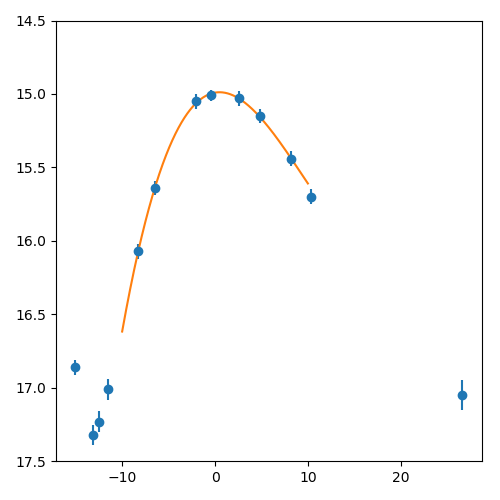

In [9]:
plt.figure(figsize=(5,5))
plt.errorbar(Bmjd-toffset, Bmag, Bmag_unc, fmt='o')
plt.ylim(17.5,14.5)

theta = ml_res.x
t_grid = np.linspace(-10, 10,1000)

plt.plot(t_grid, theta[0] + theta[1]*t_grid + theta[2]*t_grid**2 + theta[3]*t_grid**3)
plt.tight_layout()

In [10]:
ml_guess = ml_res.x
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim

nwalkers = 25

#initial position of walkers
rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
pos = ml_guess*rand_pos


In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=(Bmjd[near_peak]-toffset, 
                                      Bmag[near_peak], 
                                      Bmag_unc[near_peak]))


max_samples = 100000

old_tau = np.inf
for sample in sampler.sample(pos, 
                             iterations=max_samples, 
                             progress=True):
    if sampler.iteration % int(2e3):
        continue
    

    tau = sampler.get_autocorr_time(tol=0)

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 14%|█▍        | 14000/100000 [00:12<01:19, 1084.10it/s]


In [12]:
tau

array([48.32081719, 45.46710042, 50.67917832, 46.71175953])

<IPython.core.display.Javascript object>


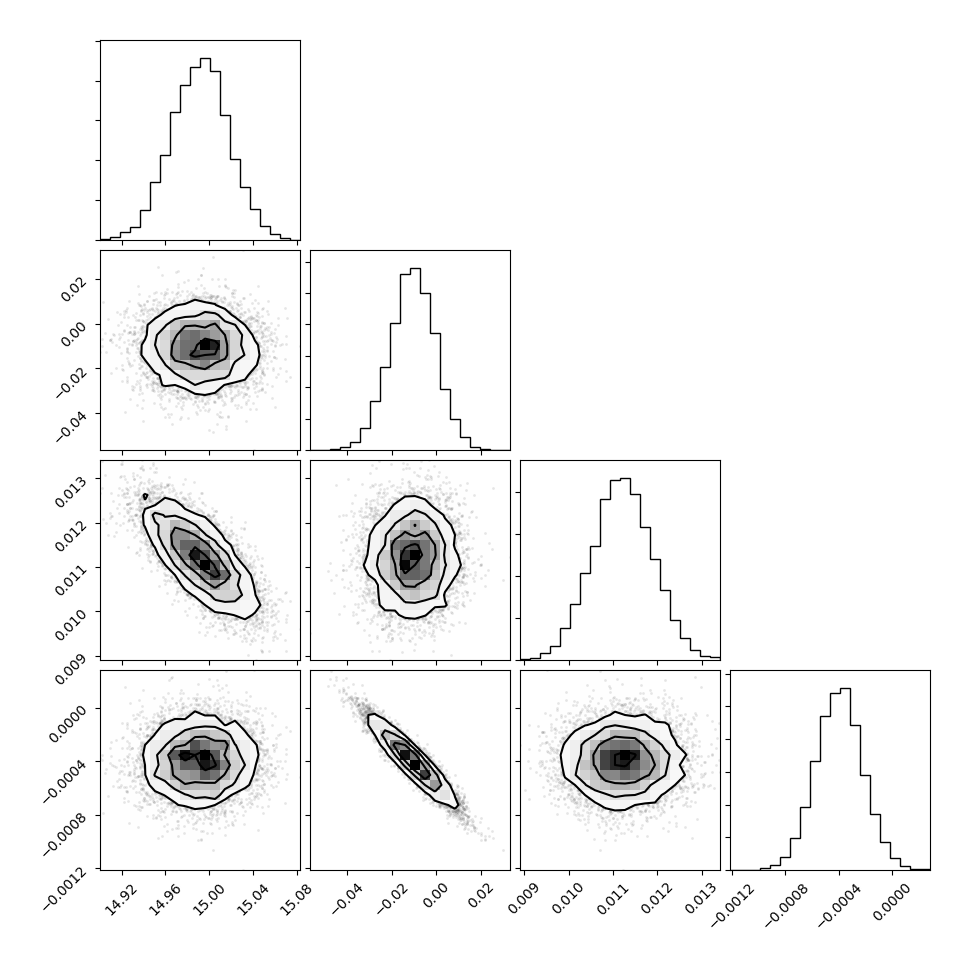

In [13]:
samples = sampler.get_chain(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int))
fig = corner.corner(samples)

<IPython.core.display.Javascript object>


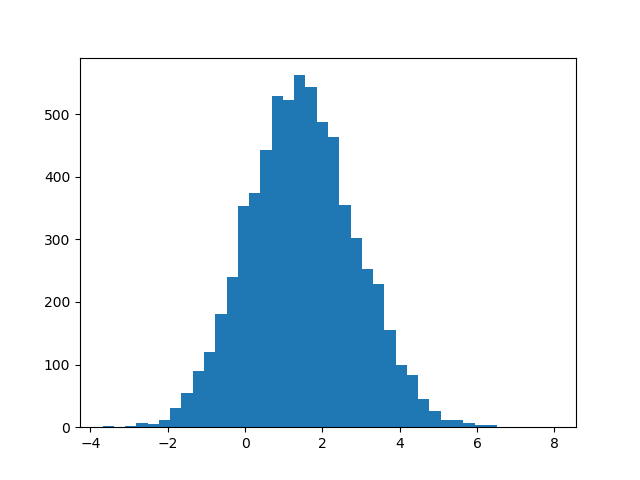

68% CR on t_peak is: [58862.06651997 58863.44751229 58864.89549282]


In [14]:
# derivative gives quadratic
# (-b +/- sqrt(b**2 - 4*a*c))/2a


t_peak = (-2*samples[:,2] + np.sqrt(4*samples[:,2]**2 - 4*samples[:,1]*3*samples[:,3]))/(2*samples[:,3])
plt.figure()
plt.hist(t_peak, bins=40)

print('68% CR on t_peak is: {}'.format(np.percentile(t_peak, (15.865,50,84.135)) + toffset))

[ 58.74242132  47.7901781  108.68066815 ...  36.52597672  31.22625992
  45.29225699]


<IPython.core.display.Javascript object>


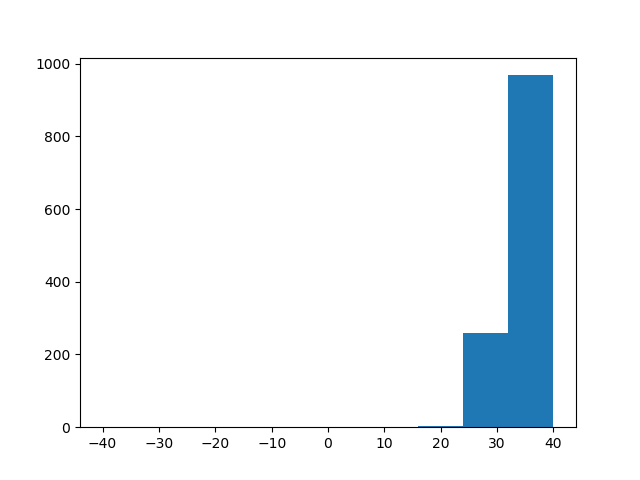

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   2., 258., 968.]),
 array([-40., -32., -24., -16.,  -8.,   0.,   8.,  16.,  24.,  32.,  40.]),
 <a list of 10 Patch objects>)

In [15]:
t_peak = (-2*samples[:,2] - np.sqrt(4*samples[:,2]**2 - 4*samples[:,1]*3*samples[:,3]))/(2*samples[:,3])
print(t_peak)
plt.figure()
plt.hist(t_peak, range=(-40,40))

In [16]:
samples[0]

array([ 1.49703973e+01, -1.25438785e-02,  1.11891261e-02, -3.70049968e-04])

### Fit a quadratic function

In [47]:
def lnlike(theta, t, m, m_unc):
    
    p0, p1, p2 = theta
    
    model = p0 + p1*t + p2*t**2
    
    lnl = -0.5*np.sum((m - model)**2/m_unc**2)
    
    return lnl

def neg_lnlike(theta, t, m, m_unc):
    return -1*lnlike(theta, t, m, m_unc)

[ 1.50024062e+01 -2.77053971e-02  1.03367505e-02]


<IPython.core.display.Javascript object>


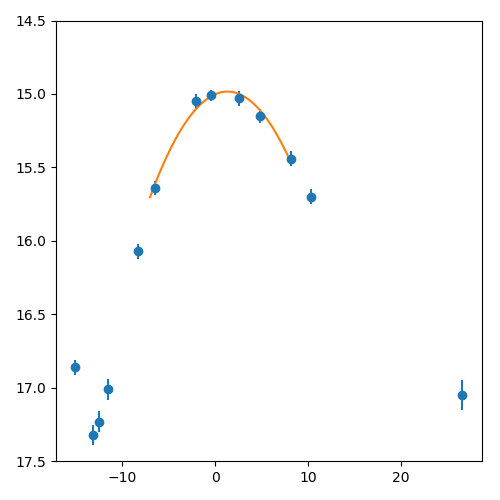

In [18]:
near_peak = np.where((Bmjd > 58855) & (Bmjd < 58871))

ml_res = minimize(neg_lnlike, (15, -0.05,0.01), method='Powell', # Powell method does not need derivatives
                      args=(Bmjd[near_peak]-toffset, Bmag[near_peak], Bmag_unc[near_peak]))
print(ml_res.x)

plt.figure(figsize=(5,5))
plt.errorbar(Bmjd-toffset, Bmag, Bmag_unc, fmt='o')
plt.ylim(17.5,14.5)

theta = ml_res.x
t_grid = np.linspace(-7, 8,1000)

plt.plot(t_grid, theta[0] + theta[1]*t_grid + theta[2]*t_grid**2)
plt.tight_layout()

In [19]:
ml_guess = ml_res.x
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim

nwalkers = 25

#initial position of walkers
rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
pos = ml_guess*rand_pos

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=(Bmjd[near_peak]-toffset, 
                                      Bmag[near_peak], 
                                      Bmag_unc[near_peak]))


max_samples = 100000

old_tau = np.inf
for sample in sampler.sample(pos, 
                             iterations=max_samples, 
                             progress=True):
    if sampler.iteration % int(2e3):
        continue
    

    tau = sampler.get_autocorr_time(tol=0)

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 24%|██▍       | 24000/100000 [00:18<00:58, 1301.53it/s]


<IPython.core.display.Javascript object>


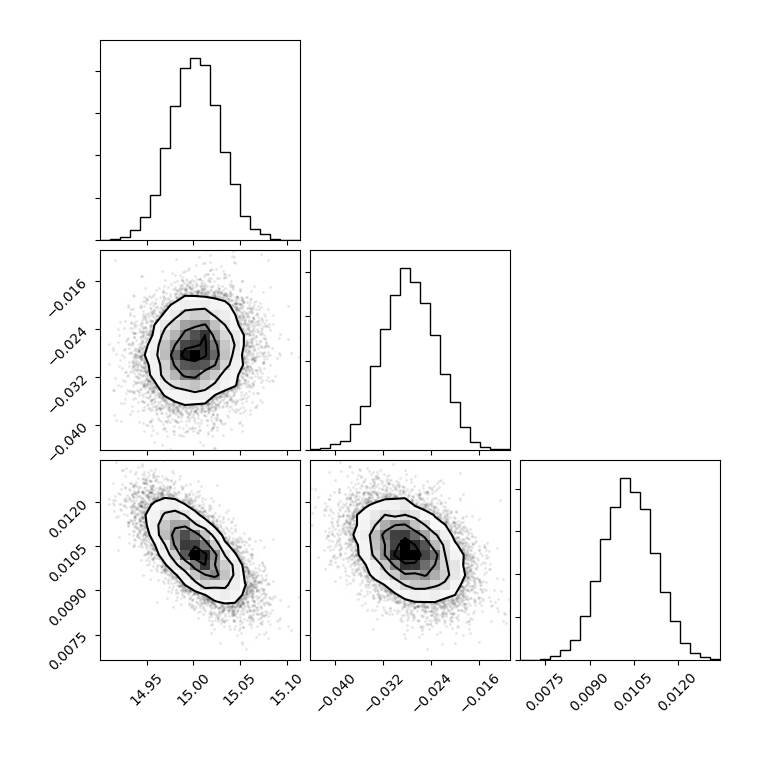

In [20]:
samples = sampler.get_chain(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int))
fig = corner.corner(samples)

<IPython.core.display.Javascript object>


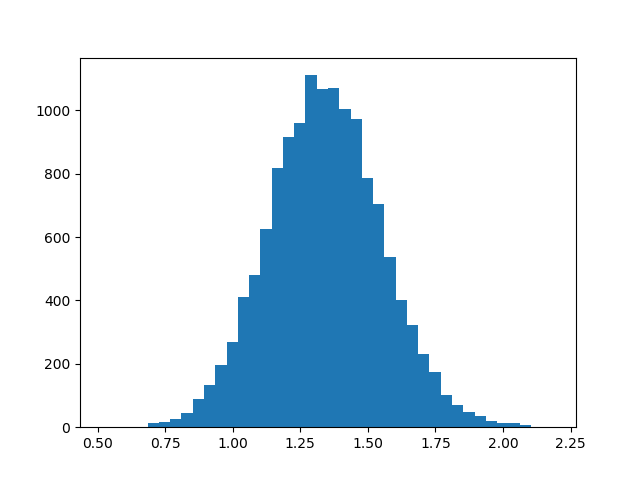

68% CR on t_peak is: [58863.13609537 58863.33933654 58863.54892692]


In [21]:
# derivative gives linear term
# peak = 


t_peak = -samples[:,1]/(2*samples[:,2])
plt.figure()
plt.hist(t_peak, bins=40)

print('68% CR on t_peak is: {}'.format(np.percentile(t_peak, (15.865,50,84.135)) + toffset))

<IPython.core.display.Javascript object>


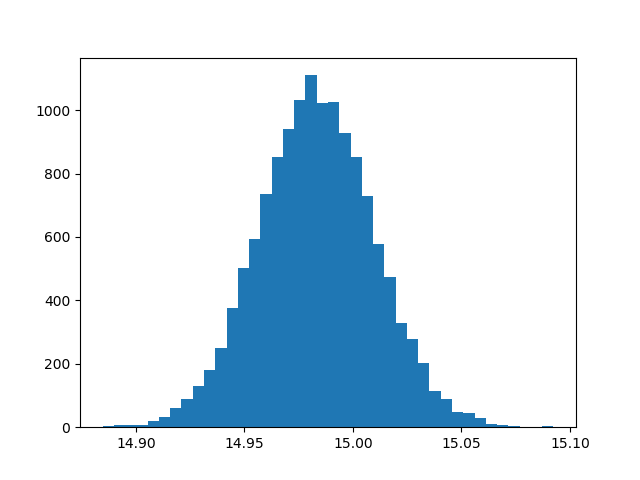

68% CR on B_max is: [14.95680708 14.98297052 15.0096622 ]


In [22]:
b_max = samples[:,0] + samples[:,1]*t_peak + samples[:,2]*t_peak**2
plt.figure()
plt.hist(b_max, bins=40)

print('68% CR on B_max is: {}'.format(np.percentile(b_max, (15.865,50,84.135))))

## Compare Swift and CSP to estimate bias in b-band maximum vs. B-band maximum

Using the time of $B$-band maximum estimated in CSP data [(Krisciunas+17)](https://ui.adsabs.harvard.edu/abs/2017AJ....154..211K/abstract), we can then use SOUSA Swift b-band light curves to estimate the time of $b$-band maximum and compare the results.

In [37]:
csp_df = pd.read_csv('../data/comp_sne/CSP/Krisciunas17.tab3', 
                     skiprows=6, comment='#', delim_whitespace=True,
                     names=['SN', 'tbmax', 'tbmax_unc', 
                            'tbmax_template', 'tbmax_template_unc',
                            'dm15b', 'dm15b_unc', 
                            'dm15b_template', 'dm15b_template_unc',
                            'sbv', 'sbv_unc', 'sbv_template', 'sbv_template_unc'])
csp_df.head()

,SN,tbmax,tbmax_unc,tbmax_template,tbmax_template_unc,dm15b,dm15b_unc,dm15b_template,dm15b_template_unc,sbv,sbv_unc,sbv_template,sbv_template_unc
0,2004dt,-999.00,-99.00,53234.72,0.73,-999.000,-99,1.067,0.081,-999,-99.000,1.189,0.061
1,2004ef,53263.77,0.12,53264.38,0.77,1.353,0.014,1.371,0.060,0.846,0.007,0.816,0.060
2,2004eo,53278.24,0.08,53278.53,0.60,1.389,0.010,1.339,0.060,0.835,0.010,0.824,0.060
3,2004ey,53303.73,0.13,53304.18,0.60,0.954,0.040,0.950,0.061,1.088,0.008,1.010,0.060
4,2004gc,-999.00,-99.00,53324.78,0.98,-999.000,-99,1.098,0.084,-999,-99.000,0.923,0.064


 16%|█▌        | 16000/100000 [00:12<01:07, 1251.06it/s]


<IPython.core.display.Javascript object>


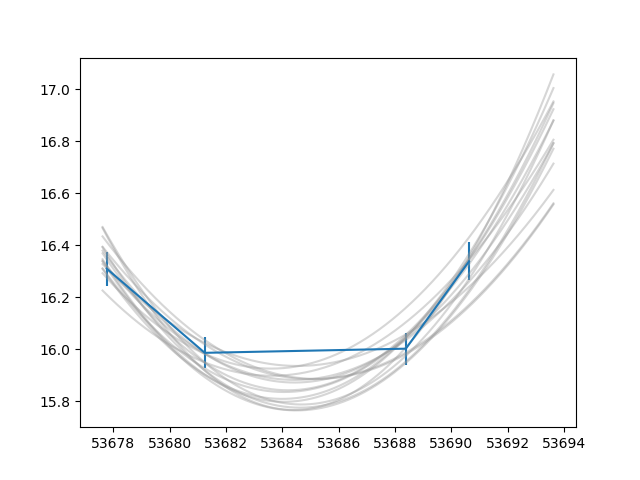

SN2005hk peak is -0.3435 +/- 0.2935 (4 obs; sys unc = 0.1)


 30%|███       | 30000/100000 [00:25<00:59, 1185.13it/s]


<IPython.core.display.Javascript object>


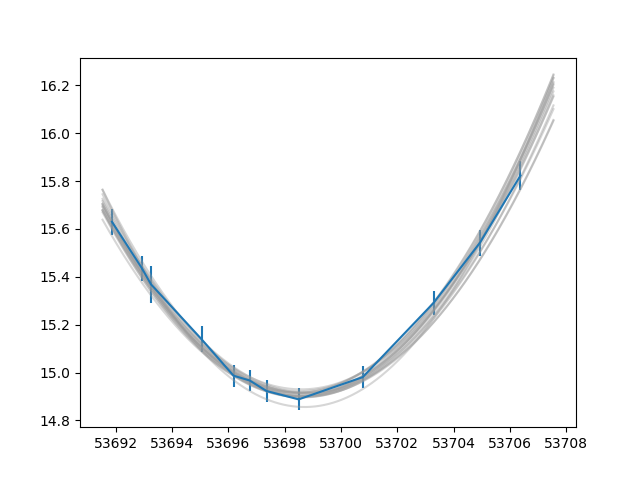

SN2005ke peak is 0.1025 +/- 0.1115 (12 obs; sys unc = 0.09)


 24%|██▍       | 24000/100000 [00:20<01:04, 1175.65it/s]


<IPython.core.display.Javascript object>


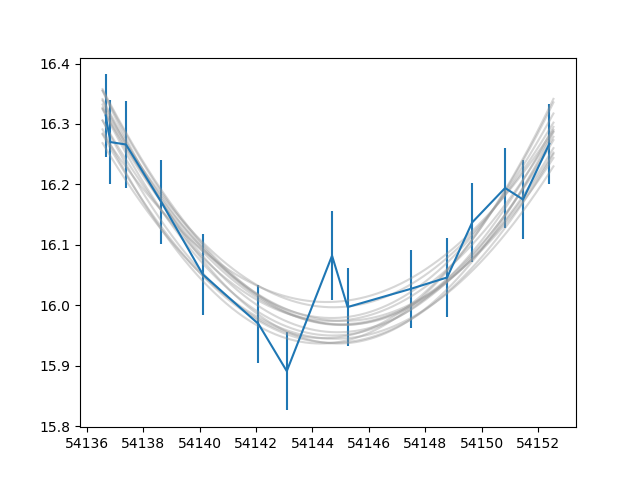

SN2007S peak is 1.0655 +/- 0.3167 (15 obs; sys unc = 0.86)


 22%|██▏       | 22000/100000 [00:18<01:06, 1164.93it/s]


<IPython.core.display.Javascript object>


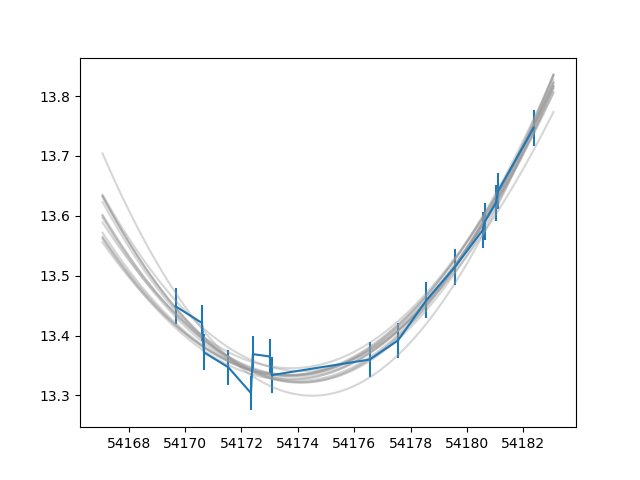

SN2007af peak is -0.0294 +/- 0.2420 (17 obs; sys unc = 0.24)


 16%|█▌        | 16000/100000 [00:14<01:14, 1130.00it/s]


<IPython.core.display.Javascript object>


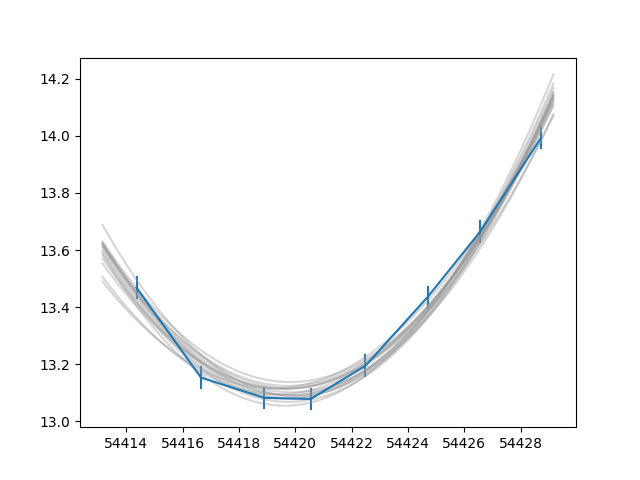

SN2007on peak is -0.4641 +/- 0.1767 (8 obs; sys unc = 0.09)


 16%|█▌        | 16000/100000 [00:14<01:18, 1071.26it/s]


<IPython.core.display.Javascript object>


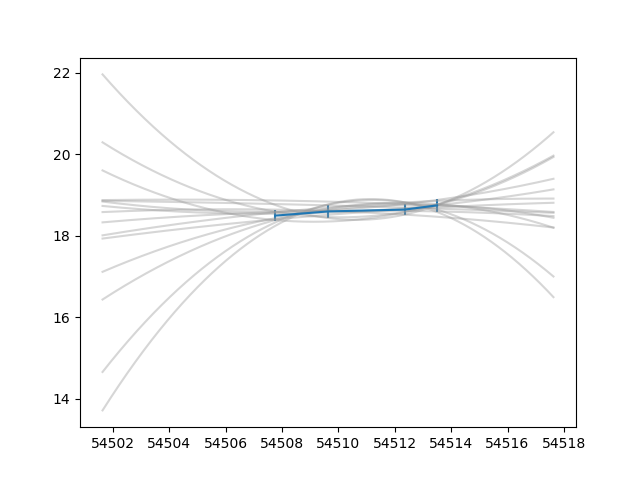

SN2008ae peak is 1.9678 +/- 2.1634 (4 obs; sys unc = 0.6)


 22%|██▏       | 22000/100000 [00:18<01:06, 1177.43it/s]


<IPython.core.display.Javascript object>


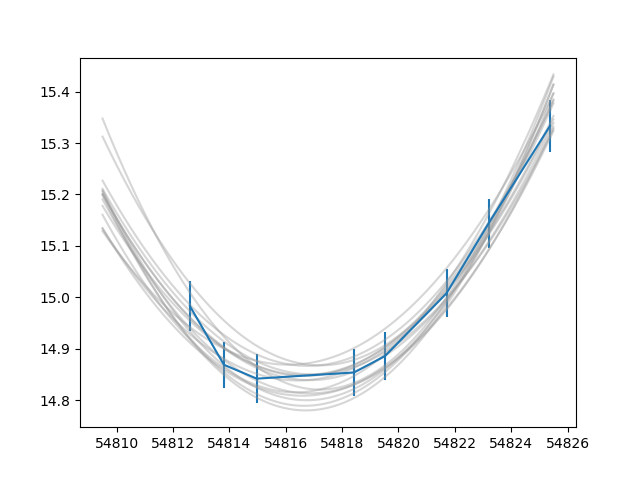

SN2008hv peak is 0.2577 +/- 0.4284 (8 obs; sys unc = 0.27)


 24%|██▍       | 24000/100000 [00:20<01:04, 1184.50it/s]


<IPython.core.display.Javascript object>


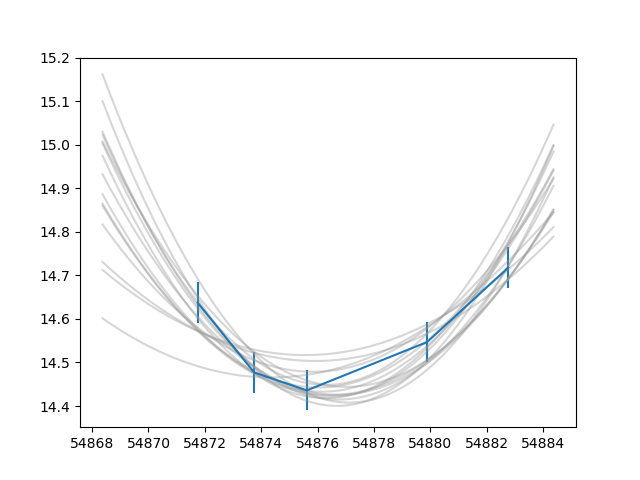

SN2009Y peak is 1.2389 +/- 0.3798 (5 obs; sys unc = 0.2)


 16%|█▌        | 16000/100000 [00:13<01:11, 1171.70it/s]


<IPython.core.display.Javascript object>


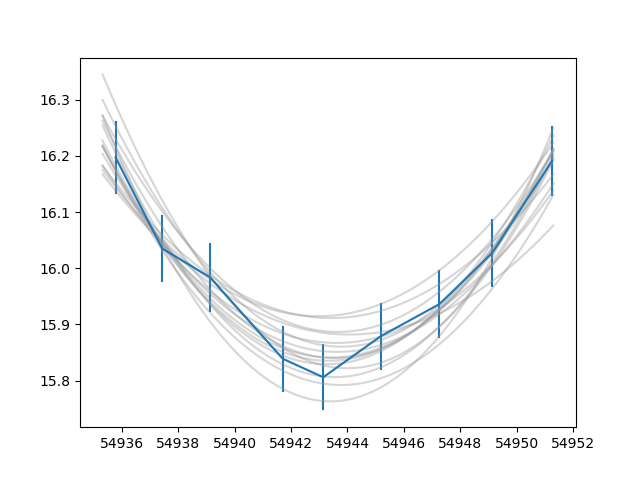

SN2009cz peak is 1.1482 +/- 0.3453 (9 obs; sys unc = 0.18)


In [92]:
# find CSP SNe with Swift phot
swift_dir = '../data/comp_sne/SOUSA/'
swift_files = glob.glob(swift_dir + '*dat')
swift_sn = [x.split('/')[-1].split('_')[0][2:] for x in swift_files]

offset = []
offset_unc = []

for sn, tbmax, tbmax_unc in zip(csp_df.SN, csp_df.tbmax, csp_df.tbmax_unc):
    if tbmax > 0 and sn in swift_sn:
    
        swift_sn_df = pd.read_csv(swift_dir + 'SN{}_uvotB15.1.dat'.format(sn), 
                                  delim_whitespace=True, comment='#',
                                  names=['Filter', 'MJD', 'Mag', 'MagErr', 
                                         '3SigMagLim', '0.98SatLim', 'Rate', 
                                         'RateErr', 'Ap', 'Frametime', 'Exp', 
                                         'Telapse'])
        b_obs = np.where(swift_sn_df.Filter == 'B')
        t = swift_sn_df.iloc[b_obs].MJD.values
        mag = swift_sn_df.iloc[b_obs].Mag.values
        mag_unc = swift_sn_df.iloc[b_obs].MagErr.values
        near_peak = np.where((t > tbmax - 7) & (t < tbmax+9))

        if len(near_peak[0]) > 3:
            ml_res = minimize(neg_lnlike, (15, -0.05,0.01), method='Powell', # Powell method does not need derivatives
                          args=(t[near_peak]-tbmax, mag[near_peak], mag_unc[near_peak]))

            ml_guess = ml_res.x
            ndim = len(ml_guess)
            nfac = [10**(-2.5)]*ndim

            nwalkers = 25

            #initial position of walkers
            rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
            pos = ml_guess*rand_pos

            sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                            args=(t[near_peak]-tbmax, 
                                                  mag[near_peak], 
                                                  mag_unc[near_peak]))


            max_samples = 100000

            old_tau = np.inf
            for sample in sampler.sample(pos, 
                                         iterations=max_samples, 
                                         progress=True):
                if sampler.iteration % int(2e3):
                    continue


                tau = sampler.get_autocorr_time(tol=0)

                # Check convergence
                converged = np.all(tau * 100 < sampler.iteration)
                converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
                if converged:
                    break
                old_tau = tau

            samples = sampler.get_chain(flat=True,
                                        discard=10*np.ceil(np.max(tau)).astype(int),
                                        thin=np.ceil(np.max(tau)).astype(int))
            plt.figure()
            plt.errorbar(t[near_peak], mag[near_peak], mag_unc[near_peak])
            t_grid = np.linspace(-7,9, 1000)
            for samp in samples[np.random.choice(len(samples), 15)]:
                plt.plot(t_grid + tbmax, np.polyval(samp[::-1], t_grid), '0.6', alpha=0.4)
            
            t_peak = -samples[:,1]/(2*samples[:,2])
            print('SN{} peak is {:.4f} +/- {:.4f} ({} obs; sys unc = {})'.format(sn, 
                                                                                 np.median(t_peak), 
                                                                                 np.diff(np.percentile(t_peak, (16,84)))[0]/2,
                                                                                 len(near_peak[0]),
                                                                                 tbmax_unc))
            
            offset.append(np.median(t_peak))
            offset_unc.append(np.hypot(np.diff(np.percentile(t_peak, (16,84)))[0]/2,
                                       tbmax_unc))
            time.sleep(0.5)

In [103]:
print(np.median(offset))
print(np.mean(offset))
print(np.sum(np.array(offset)/np.array(offset_unc)**2)/np.sum(1/np.array(offset_unc)**2))

0.25771193888246563
0.5493071114585345
0.05730499132213623
